In [193]:
import datetime
import numpy as np
import polars as pl
import geopandas as gpd
import xarray as xr
import rioxarray

import matplotlib.pyplot as plt


In [7]:
RAIN_COL = "rain_mm"

EASTING_RANGE = [276000, 320500] ## based on data I have
NORTHING_RANGE = [258000, 301500] ## based on data I have

# Load data

## Load CEH-GEAR

In [130]:
ceh_plynlimon = xr.open_dataset('../../../CEH_GEAR/ceh_1km_plynlimonregion_19760101_20101231.nc')
ceh_plynlimon = ceh_plynlimon.rename({'rainfall_amount': RAIN_COL})

## Load HGHT grid

In [13]:
severn_hght = rioxarray.open_rasterio('../../../Spatial Data/HGHT_SEVERN_1km_CEHGrid.tif')
severn_hght = severn_hght.sortby('y')
severn_hght = severn_hght.sel(band=1)

severn_hght = severn_hght.sel(x=slice(*EASTING_RANGE), y=slice(*NORTHING_RANGE))

## Load gauge metadata

In [135]:
## monthly gauges
plynlimon_monthly_gauges = pl.read_csv('../gauge_data/mo_monthly_gauges_plynlimon.csv', try_parse_dates=True)

In [134]:
# daily metadata
plynlimon_metadata = pl.read_csv('../gauge_data/mo_plynlimon_area_metadata.csv')
plynlimon_metadata = plynlimon_metadata.with_columns(
    pl.col("ID").is_in(plynlimon_monthly_gauges['ID']).alias('IS_MONTHLY_GAUGE')
)

In [136]:
## Load gauge data (QC'd version)
plynlimon_all_gauges = pl.read_csv('../gauge_data/mo_daily_plynlimon_gauges.csv', try_parse_dates=True, new_columns=["gauge_id", "time", f'{RAIN_COL}_gauge', "mo_flag"])

# Load shapefiles (optional)

In [194]:
plynlimon_shp = gpd.read_file('../plynlimon_catchment_boundary/54022/54022.shp')
bewdley_shp = gpd.read_file('../../FDRI-catchment-contribution-to-floods/River Severn/Catchment_Data/Bewdley/54001/54001.shp')

# Shift grid

In [137]:
def coerse_data_into_haduk_format(data, offset, xrange, yrange):
    """
    Quick fix for coersing data to have same grid as HADUK.
    """
    data = data.assign_coords(x=(data['x'] + offset))
    data = data.assign_coords(y=(data['y'] + offset))
    data = data.sel(x=xrange, y=yrange)
    return data


In [138]:
ceh_plynlimon_hght = coerse_data_into_haduk_format(ceh_plynlimon, offset=500, xrange=slice(*EASTING_RANGE), yrange=slice(*NORTHING_RANGE))

In [139]:
ceh_plynlimon_hght['hght'] = severn_hght

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

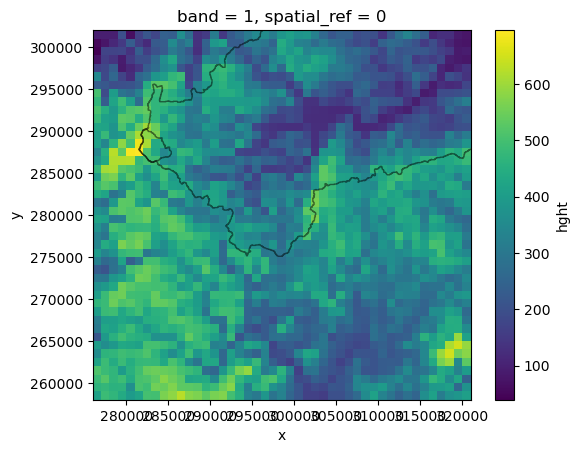

In [196]:
fig, ax = plt.subplots(1)
(ceh_plynlimon_hght['hght']/10).plot(ax=ax)
plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.5)
bewdley_shp.plot(ax=ax, facecolor='none', alpha=.5)

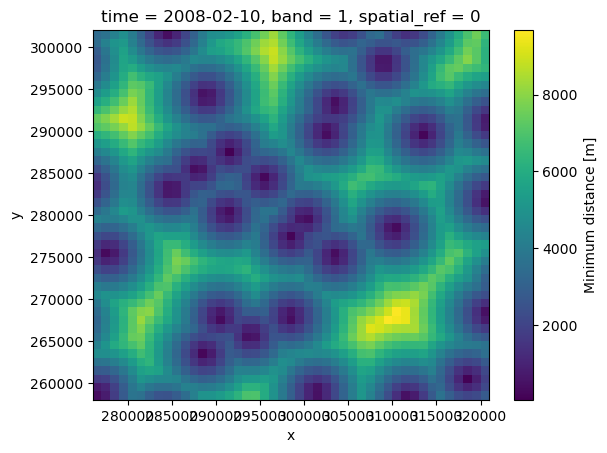

In [141]:
ceh_plynlimon_hght['min_dist'].sel(time="2008-02-10").plot()

In [142]:
changes_in_dist = ceh_plynlimon_hght['min_dist'].diff(dim='time').sum(('x', 'y'))
change_dates = changes_in_dist.where(changes_in_dist != 0).dropna(dim='time')['time']
big_changes_dates = changes_in_dist.where(abs(changes_in_dist) > 500000).dropna(dim='time')['time']
big_changes_dates

<xarray.DataArray 'time' (time: 77)> Size: 616B
array(['1976-12-01T00:00:00.000000000', '1978-11-01T00:00:00.000000000',
       '1978-12-01T00:00:00.000000000', '1979-01-01T00:00:00.000000000',
       '1979-04-01T00:00:00.000000000', '1979-12-01T00:00:00.000000000',
       '1980-01-01T00:00:00.000000000', '1980-04-01T00:00:00.000000000',
       '1981-07-01T00:00:00.000000000', '1981-12-01T00:00:00.000000000',
       '1982-10-01T00:00:00.000000000', '1983-10-01T00:00:00.000000000',
       '1984-01-01T00:00:00.000000000', '1984-04-01T00:00:00.000000000',
       '1985-05-01T00:00:00.000000000', '1988-03-01T00:00:00.000000000',
       '1988-04-01T00:00:00.000000000', '1988-11-01T00:00:00.000000000',
       '1991-01-01T00:00:00.000000000', '1991-05-01T00:00:00.000000000',
       '1991-06-01T00:00:00.000000000', '1991-12-01T00:00:00.000000000',
       '1992-02-01T00:00:00.000000000', '1992-05-01T00:00:00.000000000',
       '1992-06-01T00:00:00.000000000', '1992-07-01T00:00:00.000000000',
       '1992-09-01T00:00:00.000000000', '1992-10-01T00:00:00.000000000',
       '1993-01-01T00:00:00.000000000', '1994-09-01T00:00:00.000000000',
       '1995-07-01T00:00:00.000000000', '1996-01-01T00:00:00.000000000',
       '1996-02-01T00:00:00.000000000', '1996-04-01T00:00:00.000000000',
       '1996-05-01T00:00:00.000000000', '1996-12-01T00:00:00.000000000',
       '1996-12-31T00:00:00.000000000', '1997-02-01T00:00:00.000000000',
       '1997-09-01T00:00:00.000000000', '1997-09-04T00:00:00.000000000',
       '1997-11-01T00:00:00.000000000', '1998-12-01T00:00:00.000000000',
       '1999-04-01T00:00:00.000000000', '1999-09-01T00:00:00.000000000',
       '1999-10-01T00:00:00.000000000', '2001-02-01T00:00:00.000000000',
       '2001-02-28T00:00:00.000000000', '2001-06-01T00:00:00.000000000',
       '2001-09-01T00:00:00.000000000', '2002-01-01T00:00:00.000000000',
       '2002-12-01T00:00:00.000000000', '2003-03-01T00:00:00.000000000',
       '2003-04-01T00:00:00.000000000', '2003-07-01T00:00:00.000000000',
       '2003-10-01T00:00:00.000000000', '2003-12-01T00:00:00.000000000',
       '2004-01-01T00:00:00.000000000', '2004-02-01T00:00:00.000000000',
       '2004-04-01T00:00:00.000000000', '2004-06-01T00:00:00.000000000',
       '2004-07-01T00:00:00.000000000', '2004-09-01T00:00:00.000000000',
       '2005-01-01T00:00:00.000000000', '2005-02-01T00:00:00.000000000',
       '2005-03-01T00:00:00.000000000', '2006-01-01T00:00:00.000000000',
       '2006-06-01T00:00:00.000000000', '2006-07-01T00:00:00.000000000',
       '2006-10-01T00:00:00.000000000', '2006-11-01T00:00:00.000000000',
       '2007-05-01T00:00:00.000000000', '2007-06-01T00:00:00.000000000',
       '2007-09-01T00:00:00.000000000', '2007-10-01T00:00:00.000000000',
       '2010-01-01T00:00:00.000000000', '2010-11-01T00:00:00.000000000',
       '2010-12-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 616B 1976-12-01 1978-11-01 ... 2010-12-01
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    long_name:  Time in days since 1800-1-1 (on 1976-1-1: day 64282)

In [188]:
def get_gauge_metadata_on_date(date):
    plynlimon_gauges_on_date = plynlimon_all_gauges.filter(pl.col("time") == date)
    plyn_gauge_ids = plynlimon_gauges_on_date['gauge_id'].unique()
    plyn_metadata_on_date = plynlimon_metadata.filter(pl.col("ID").is_in(plyn_gauge_ids))
    return plyn_metadata_on_date

def plot_gauge_scatter(plyn_metadata_on_date, ax):
    for plyn_row in plyn_metadata_on_date.iter_rows(named=True):
        if plyn_row['IS_MONTHLY_GAUGE']:
            ax.scatter(plyn_row['EASTING'], plyn_row['NORTHING'], edgecolor='y', facecolor='None', linewidths=1.5,  alpha=.7)
        else:
            ax.scatter(plyn_row['EASTING'], plyn_row['NORTHING'], edgecolor='r', facecolor='None', linewidths=1.5, alpha=.8)
    return ax

In [200]:
for ind, change_date in enumerate(change_dates):
    fig, ax = plt.subplots(1, figsize=(7, 4))
    ceh_plynlimon_hght['min_dist'].sel(time=change_date).plot(vmin=0, vmax=14000, ax=ax)
    ax.set_title(f"{change_date.dt.strftime("%d %b %Y").data}")
    plyn_metadata_on_date = get_gauge_metadata_on_date(change_date)
    ax = plot_gauge_scatter(plyn_metadata_on_date, ax)
    plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.5)
    bewdley_shp.plot(ax=ax, facecolor='none', alpha=.5)
    # fig.savefig(f'../../min_dist_plynlimon/{ind}_min_dist_plyn_{change_date.dt.strftime("%d_%b_%Y").data}.png', bbox_inches='tight')
    # plt.close()